# Libraries

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdmolfiles import MolFragmentToSmiles
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame
from IPython.display import HTML
IPythonConsole.molSize = (600,300)
IPythonConsole.drawOptions.addAtomIndices = True

def show_df(df):
    return HTML(df.to_html(notebook=True))

# Defining the functions

In [2]:
def get_biggest_ringsys(mol, includeSpiro=False):

    """
    Returns the atom indexes of the largest ring system present in a structure

    Parameters:
    mol: rdkit.Chem.rdchem.mol object easly obtained by converting the SMILES to mol using RDKit
    includeSpiro: A boolean flag for including spiro stuff or not
    """    

    ri = mol.GetRingInfo()
    systems = []

    if len(ri.AtomRings()) == 0:
        # If the structure has no ring, return a Carbon-Carbon
        return [0]

    for ring in ri.AtomRings():
        ringAts = set(ring) # atoms in the current ring
        nSystems = [] # ring systems
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            # Checking if there are any common atoms with any ring system to merge
            if nInCommon and (includeSpiro or nInCommon>1): 
                ringAts = ringAts.union(system) # merging a set
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems

    return max(systems, key=len)

In [3]:
def get_max_ring_with_adjancent(molecule):
    """
    Returns the indexes of the biggest ring system and the immediate adjancent atoms

    Parameters:
    molecule: rdkit.Chem.rdchem.mol object easly obtained by converting the SMILES to mol using RDKit
    """
    
    # Get the largest ring system in the molecule atom indexes
    max_ring = get_biggest_ringsys(molecule, includeSpiro=True)

    # # Check if there is any ring
    # if isinstance(max_ring, Chem.Mol):
    #     #print('here')
    #     num_atoms = max_ring.GetNumAtoms()
    #     return [idx for idx in range(num_atoms)]
    max_ring_with_adjancent = set(max_ring)
    
    for ring_atom in max_ring:
        neighbors = set(molecule.GetAtomWithIdx(ring_atom).GetNeighbors()) # Searching through the neighbors
        # Appending neighbor atoms to the ring
        for neighbor_atom in neighbors:
            # If the atom is not in the biggest ring system and IS AROMATIC, we need to change its property
            if (neighbor_atom.GetIdx() not in max_ring) and (neighbor_atom.GetIsAromatic()): 
                neighbor_atom.SetIsAromatic(False)
                max_ring_with_adjancent.add(neighbor_atom.GetIdx())
            else: max_ring_with_adjancent.add(neighbor_atom.GetIdx())
    
    return max_ring_with_adjancent

# Test cases

Here are some tests I'm going to make to assess the robustness of the functions:
* Non-aromatic rings
* Normal (aromatic)
* Bridge atoms
* Lots of single rings (how to deal with that?)
* Alkenes, alkanes, alkynes
* Macrocyclics
* Non-aromatic cyclics
* Spiro

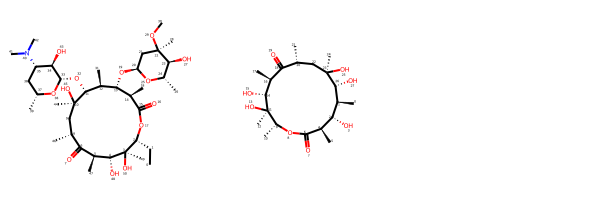

In [4]:
erythromycin = Chem.MolFromSmiles('CC[C@@H]1[C@@]([C@@H]([C@H](C(=O)[C@@H](C[C@@]([C@@H]([C@H]([C@@H]([C@H](C(=O)O1)C)O[C@H]2C[C@@]([C@H]([C@@H](O2)C)O)(C)OC)C)O[C@H]3[C@@H]([C@H](C[C@H](O3)C)N(C)C)O)(C)O)C)C)O)(C)O ')
erythromycin_fragment = Chem.MolFromSmiles(MolFragmentToSmiles(erythromycin, atomsToUse=get_max_ring_with_adjancent(erythromycin)))

Draw.MolsToGridImage([erythromycin, erythromycin_fragment])

,SMILES,NAME,TEST_CASE,TOTAL_MOL
0,CC1(OC2COC3(C(C2O1)OC(O3)(C)C)COS(=O)(=O)N)C,topiramate,non aromatic,
1,CCc1ccc(C)c2cc3cc4c(CO)cc(cc4c(C(C)O)c3cc12)c5...,"aromatic (big), not a drug",aromatic,
2,CN1CC[C@]23[C@H]4Oc5c(O)ccc(C[C@@H]1[C@@H]2C=C...,morphine,bridge atoms,
3,NC(=O)N1c2ccccc2C=Cc3ccccc13,carbamazepine,multiple rings,
4,CCCCC(C)C,isopentane,alkane,
5,CC(C)C=C,isopentene,alkene,
6,CC#CCC(C)C#C,generic alkyne,alkyne,
7,CC[C@@H]1[C@@]([C@@H]([C@H](C(=O)[C@@H](C[C@@]...,erythromycin,macrocycle,
8,C1CCC2(CC1)CCCC2,"spiro[4,5]decane",spiro,

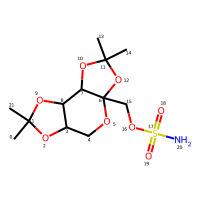
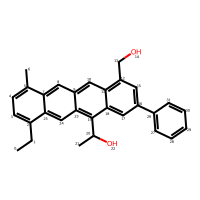
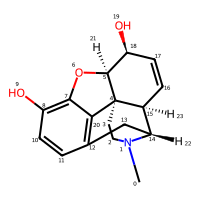
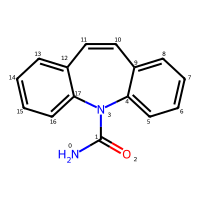
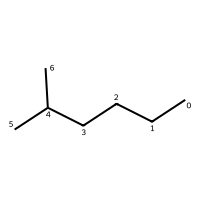
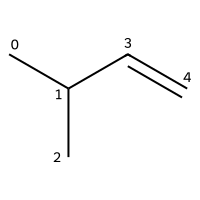
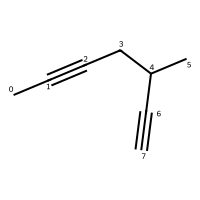
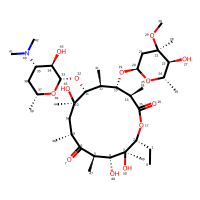
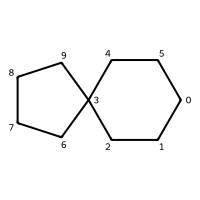

In [5]:
unit_test = pd.DataFrame({
    "SMILES":[
        'CC1(OC2COC3(C(C2O1)OC(O3)(C)C)COS(=O)(=O)N)C',
        'CCc1ccc(C)c2cc3cc4c(CO)cc(cc4c(C(C)O)c3cc12)c5ccccc5',
        'CN1CC[C@]23[C@H]4Oc5c(O)ccc(C[C@@H]1[C@@H]2C=C[C@@H]4O)c35',
        'NC(=O)N1c2ccccc2C=Cc3ccccc13',
        'CCCCC(C)C',
        'CC(C)C=C',
        'CC#CCC(C)C#C',
        'CC[C@@H]1[C@@]([C@@H]([C@H](C(=O)[C@@H](C[C@@]([C@@H]([C@H]([C@@H]([C@H](C(=O)O1)C)O[C@H]2C[C@@]([C@H]([C@@H](O2)C)O)(C)OC)C)O[C@H]3[C@@H]([C@H](C[C@H](O3)C)N(C)C)O)(C)O)C)C)O)(C)O',
        'C1CCC2(CC1)CCCC2',
    ],
    "NAME": [
        'topiramate',
        'aromatic (big), not a drug',
        'morphine',
        'carbamazepine',
        'isopentane',
        'isopentene',
        'generic alkyne',
        'erythromycin',
        'spiro[4,5]decane',

    ],
    "TEST_CASE": ['non aromatic',
                  'aromatic',
                  'bridge atoms',
                  'multiple rings',
                  'alkane',
                  'alkene',
                  'alkyne',
                  'macrocycle',
                  'spiro']})

AddMoleculeColumnToFrame(smilesCol='SMILES', molCol='TOTAL_MOL', frame=unit_test)
show_df(unit_test)

In [6]:
# Biggest ring
unit_test['BIGGEST_RING'] = unit_test['TOTAL_MOL'].apply(lambda x: Chem.MolFromSmiles(MolFragmentToSmiles(x, atomsToUse=get_biggest_ringsys(x))))

# Biggest ring with adjacent
unit_test['BIGGEST_RING_ADJACENT'] = unit_test['TOTAL_MOL'].apply(lambda x: Chem.MolFromSmiles(MolFragmentToSmiles(x, atomsToUse=get_max_ring_with_adjancent(x))))

# # Assuming 'unit_test' contains the necessary data
# list_of_smiles = unit_test['SMILES'].to_list()
# fragment_smiles = []
# for smiles in list_of_smiles:
#     mol = Chem.MolFromSmiles(smiles)
#     atomsToUse = get_biggest_ringsys(mol)
#     fragment_smiles.append(MolFragmentToSmiles(mol, atomsToUse=atomsToUse))

# print(fragment_smiles)

,SMILES,NAME,TEST_CASE,TOTAL_MOL,BIGGEST_RING,BIGGEST_RING_ADJACENT
0,CC1(OC2COC3(C(C2O1)OC(O3)(C)C)COS(=O)(=O)N)C,topiramate,non aromatic,,,
1,CCc1ccc(C)c2cc3cc4c(CO)cc(cc4c(C(C)O)c3cc12)c5...,"aromatic (big), not a drug",aromatic,,,
2,CN1CC[C@]23[C@H]4Oc5c(O)ccc(C[C@@H]1[C@@H]2C=C...,morphine,bridge atoms,,,
3,NC(=O)N1c2ccccc2C=Cc3ccccc13,carbamazepine,multiple rings,,,
4,CCCCC(C)C,isopentane,alkane,,,
5,CC(C)C=C,isopentene,alkene,,,
6,CC#CCC(C)C#C,generic alkyne,alkyne,,,
7,CC[C@@H]1[C@@]([C@@H]([C@H](C(=O)[C@@H](C[C@@]...,erythromycin,macrocycle,,,
8,C1CCC2(CC1)CCCC2,"spiro[4,5]decane",spiro,,,

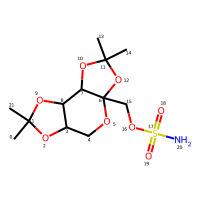
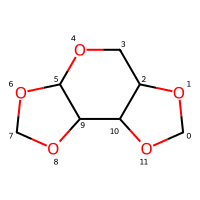
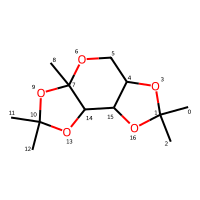
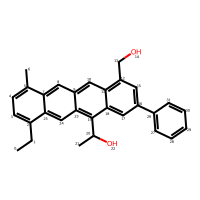
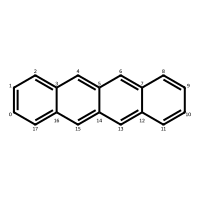
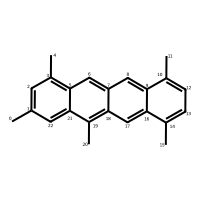
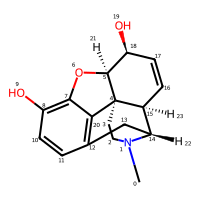
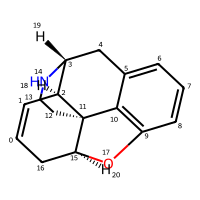
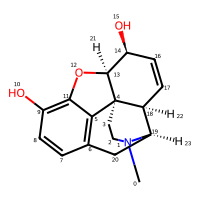
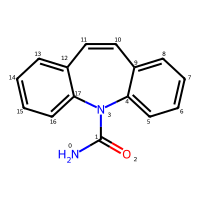
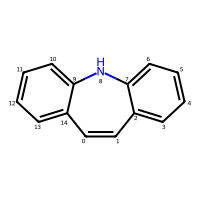
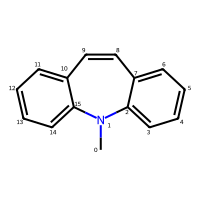
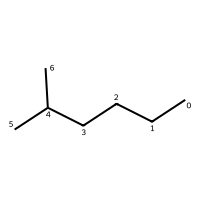
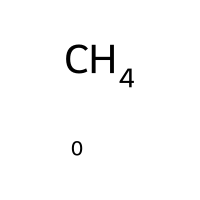
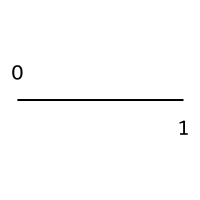
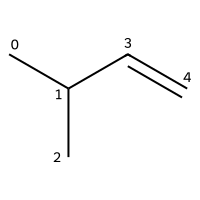
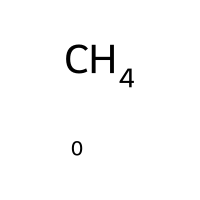
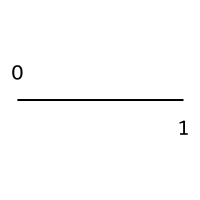
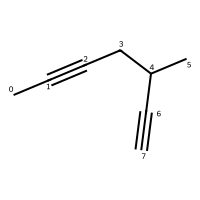
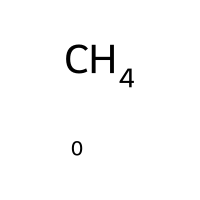
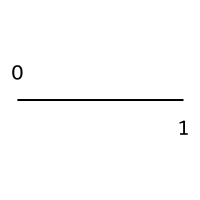
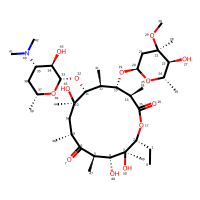
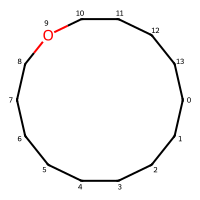
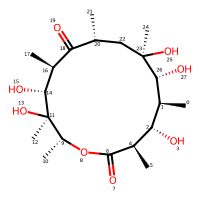
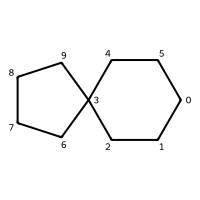
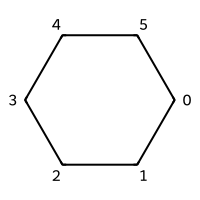
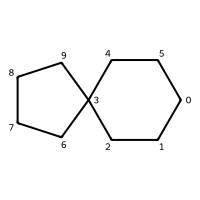

In [7]:
show_df(unit_test)

In [8]:
def get_ring_systems(mol, includeSpiro=False):
    """
    Retrieve atom indices grouped into ring systems within a given molecule.
    
    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object representing the molecular structure.
        includeSpiro (bool, optional): If True, include spiro-connected atoms in the ring systems. 
            Defaults to False.

    Returns:
        list of set: A list of sets, where each set contains the indices of atoms belonging to a ring system.
    """
    ri = mol.GetRingInfo()
    systems = []

    # Scaping
    if len(ri.AtomRings()) == 0:
        return [0] # Return a carbon
    
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))

            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems

def get_ring_adjacent(mol):
    """
    Retrieve atom indices within ring systems along with their adjacent atoms. This functions have the get_ring_systems() as a dependency;

    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object representing the molecular structure.

    Returns:
        list of set: A list of sets, where each set contains the indices of atoms in a ring system 
        along with their adjacent atoms.
    """
    ring_systems = get_ring_systems(mol, includeSpiro=False)

    rings = []
    for ring in ring_systems:
        ring_with_adjacent = set(ring)
        for ring_atom in ring:
            neighbors = set(mol.GetAtomWithIdx(ring_atom).GetNeighbors())
            
            for neighbor_atom in neighbors:
                if (neighbor_atom.GetIdx() not in ring) and (neighbor_atom.GetIsAromatic()):
                    neighbor_atom.SetIsAromatic(False)
                    ring_with_adjacent.add(neighbor_atom.GetIdx())
                else:
                    ring_with_adjacent.add(neighbor_atom.GetIdx())
        rings.append(ring_with_adjacent)

    return rings

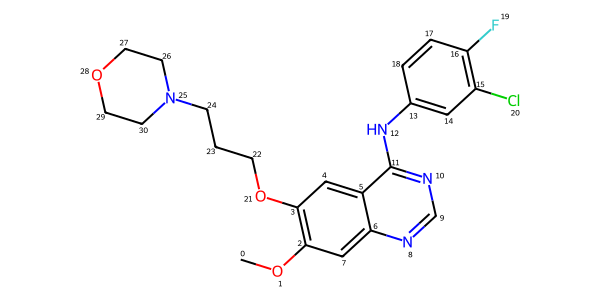

In [9]:
a = Chem.MolFromSmiles('COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4')
a

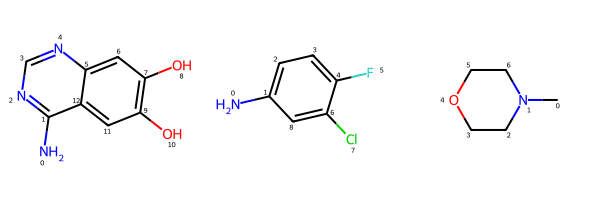

In [10]:
a = Chem.MolFromSmiles('COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4')
rings = get_ring_adjacent(a)
mols = []
for ring in rings:
    mol = Chem.MolFromSmiles(MolFragmentToSmiles(a, atomsToUse=ring))
    mols.append(mol)
Draw.MolsToGridImage(mols)

## Extrair fragmentos (anéis) dos fármacos aprovados (improviso)

In [11]:
# Design of the steps
# Get the SMILES list
fda_drugs_df = pd.read_csv('../../data/fda_approved_datasets/pre_cleaned_datasets/pre_cleaned_unique.csv')
drug_smiles = fda_drugs_df['clean_smiles'].to_list()

# Transform the SMILES into a mol object (RAW MOL OBJECT)
smiles_fragments = []
# Create a empty list to store the 'SMILES fragments'
no_smiles = []
for smiles in drug_smiles:
    mol = Chem.MolFromSmiles(smiles)
    
    # Escaping molecules with no ring:
    if get_ring_systems(mol) == [0]:
        no_smiles.append(smiles)
    else:
        rings = get_ring_adjacent(mol)
        # Get the ring systems with the adjacent atoms with the built function
        # for each ring, transform the MolFragment into SMILES
        for ring in rings:
            fragment_smiles = Chem.MolFragmentToSmiles(mol, atomsToUse=ring)
            smiles_fragments.append(fragment_smiles)

print(f'{len(no_smiles)} structures have NO RING!')
print(f'We have yielded {len(smiles_fragments)} ring fragments SMILES from approved drugs!')


# Check if any SMILES fragment is going to be wrong (Sanity check)
for smiles in smiles_fragments:
    try:
        Chem.MolFromSmiles(smiles)
    except:
        print(f'This smiles has no function: {smiles}')

88 structures have NO RING!
We have yielded 3769 ring fragments SMILES from approved drugs!


## Improvements:

* Make a dict to retrieve from which SMILES the RF came from, so we can do a visual check if it is correct using a pd.DataFrame for example;
* Think about the unit testing

### Storing the parent SMILES
Creating a dict to store the parent SMILES and compare it to the fragment it generated.

In [ ]:
# Design of the steps

# Loading the data

# Creating an list of SMILES from the data

# Create an empty list for storing the data as a list of dicts
# total_dict = []
    ## Loop through this list to generate a MOL object from SMILES
        ### Escape structures that have no Ring using get_ring_systems()
        ### If molecue has ring, then get every ring and the adjacent atoms
        ### Append new info, keeping the parent SMILES stored total_dict.append{[parent_smiles] = [fragment_smiles]}
# end

In [91]:
# Data
fda_drugs_df = pd.read_csv('../../data/fda_approved_datasets/pre_cleaned_datasets/pre_cleaned_unique.csv')
list_of_smiles = fda_drugs_df['clean_smiles'].to_list()

# Empty list
parents_and_fragments = []
no_rings = []

for smiles in list_of_smiles:
    mol = Chem.MolFromSmiles(smiles)
    if get_ring_systems(mol) == [0]:
        no_rings.append(smiles)
    else:
        rings = get_ring_adjacent(mol)
        for ring in rings:
            ring_fragment = Chem.MolFragmentToSmiles(mol, atomsToUse=ring)
            parents_and_fragments.append({f'{Chem.MolToSmiles(mol)}': ring_fragment})

# Transforming it into pd.DataFrame (wide-format)
ring_fragments_df = pd.DataFrame.from_dict(parents_and_fragments)

In [92]:
ring_fragments_df = ring_fragments_df.stack()
ring_fragments_df = ring_fragments_df.reset_index()
ring_fragments_df.rename(columns={'level_0':'index', 'level_1':'parent', 0:'fragment'}, inplace=True)
ring_fragments_df.drop(columns=['index'], inplace=True)
ring_fragments_df.head(10)

,parent,fragment
0,Cc1cn[nH]c1,Cc1cn[nH]c1
1,C1CNCCN1,C1CNCCN1
2,Nc1ccncc1,Nc1ccncc1
3,N[C@@H]1CONC1=O,N[C@@H]1CONC1=O
4,Nc1ccncc1N,Nc1ccncc1N
5,Oc1cccc(O)c1,Oc1cccc(O)c1
6,NCCc1cc[nH]n1,Cc1cc[nH]n1
7,NCCc1c[nH]cn1,Cc1c[nH]cn1
8,Cn1ccnc1S,Cn1ccnc1S
9,NC(=O)c1cnccn1,Cc1cnccn1
